<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Полезные-ссылки:" data-toc-modified-id="Полезные-ссылки:-0.0.1"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span><font color="orange">Полезные ссылки:</font></a></span></li></ul></li><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-2)" data-toc-modified-id="Общее-впечатление-(ревью-2)-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 2)</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
#Загружаем нужные библиотеки

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit 
from sklearn.metrics import mean_squared_error, make_scorer
from statsmodels.tsa.seasonal import seasonal_decompose

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 12345

In [2]:
#Загружаем данные

data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col='datetime')

In [3]:
#Посмотрим на данные

display(data)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


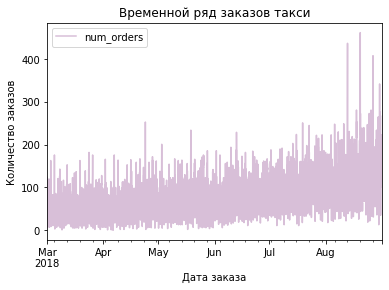

In [4]:
#Ресемпелирование по одному часу

data = data.resample('1H').sum() 
data.plot(color = '#D8BFD8')
plt.title('Временной ряд заказов такси')
plt.xlabel('Дата заказа', )
plt.ylabel('Количество заказов');

Можем заметить положительную динамику в заказах, под конец августа спрос значительно вырос. 

In [5]:
#Посмотрим на хронологию данных

print(data.index.is_monotonic)

True


Данные в хронологическом порядке. Приступим к анализу.

## Анализ

In [6]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


В среднем за час поступает 84 заказа. Минимальное количество заказов за час 0, максимальное количество 462. 

In [7]:
print('Начало сбора данных:', data.index.min())
print('Окончание сбора данных:', data.index.max())

Начало сбора данных: 2018-03-01 00:00:00
Окончание сбора данных: 2018-08-31 23:00:00


Данные собраны за полгода.

In [8]:
#Разобьем временной ряд на три составляющие: тренд, сезонность и остаток

decomposed = seasonal_decompose(data) 

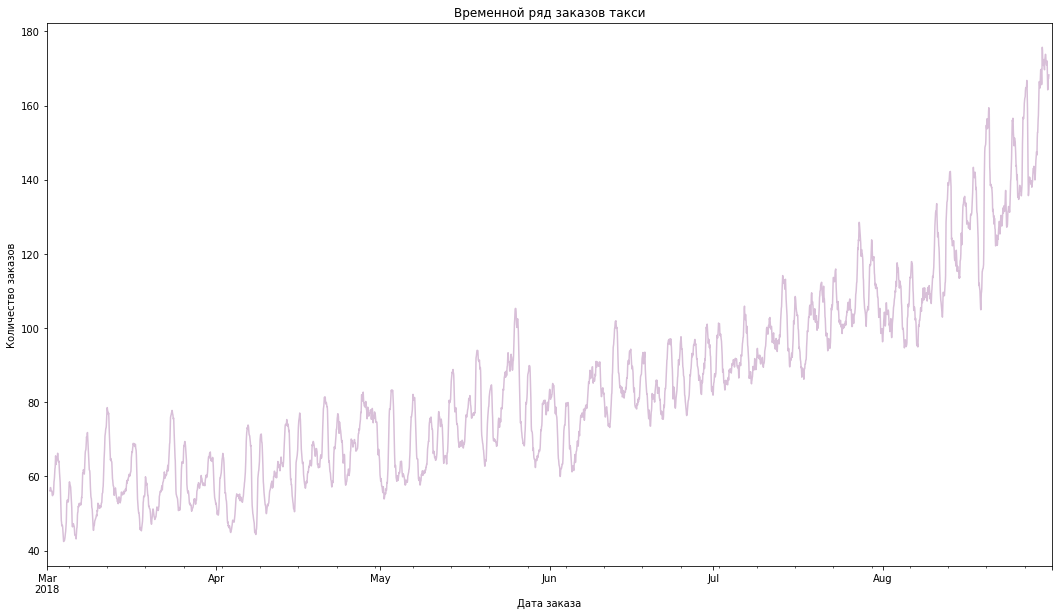

In [9]:
#Посмотрим на тренд заказа такси

decomposed.trend.plot(figsize=(18,10), color = '#D8BFD8')
plt.title('Временной ряд заказов такси')
plt.xlabel('Дата заказа', )
plt.ylabel('Количество заказов');

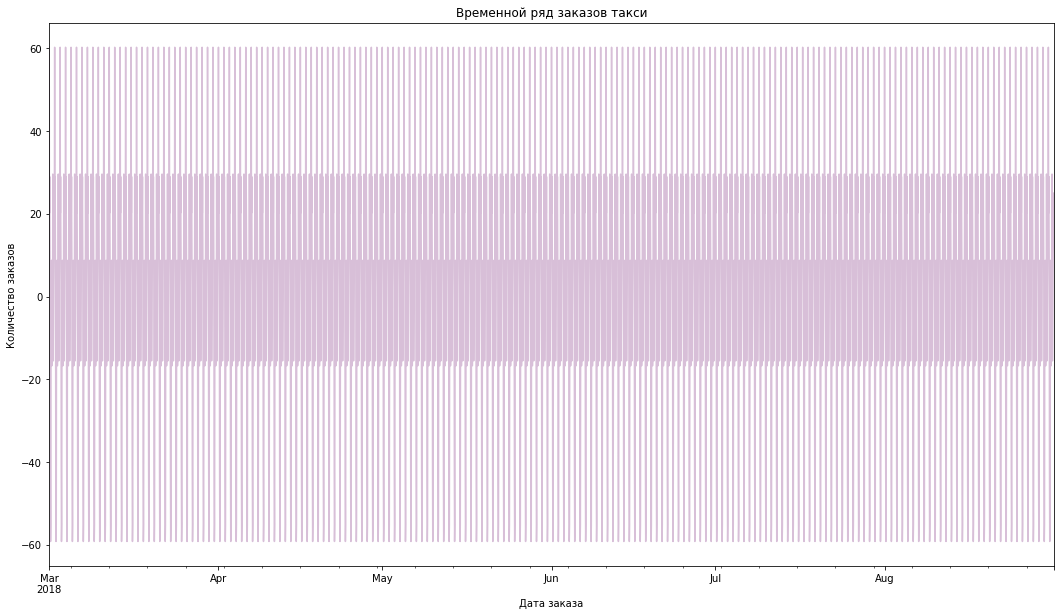

In [10]:
#Посмотрим на сезонность заказа такси

decomposed.seasonal.plot(figsize=(18,10), color = '#D8BFD8')
plt.title('Временной ряд заказов такси')
plt.xlabel('Дата заказа', )
plt.ylabel('Количество заказов');

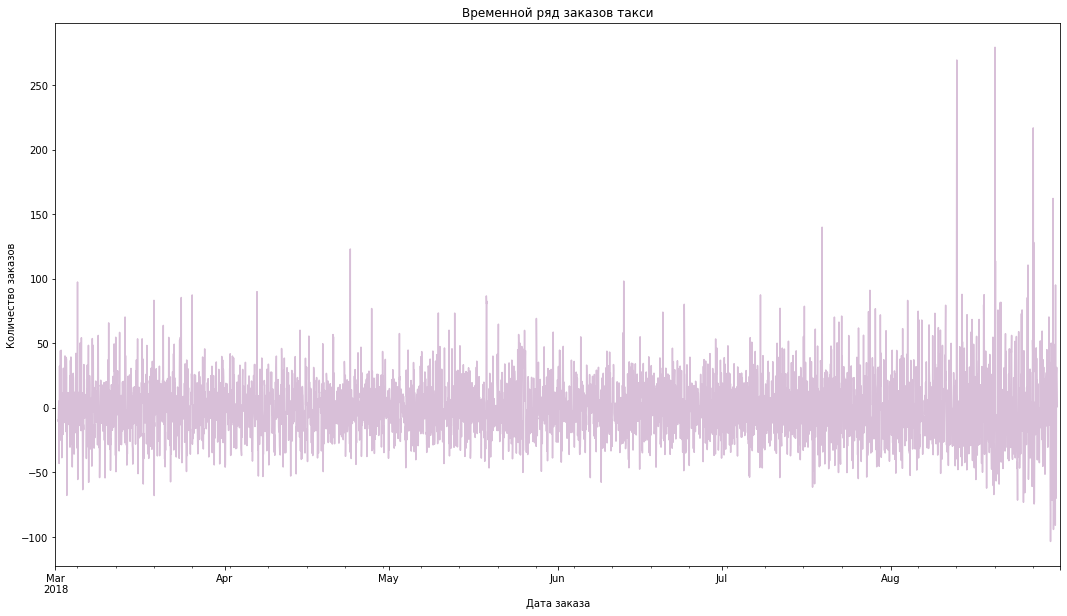

In [11]:
#Посмотрим на остаток декомпозиции заказа такси

decomposed.resid.plot(figsize=(18,10), color = '#D8BFD8')
plt.title('Временной ряд заказов такси')
plt.xlabel('Дата заказа', )
plt.ylabel('Количество заказов');

Можем заметить пиковую активность в конце августа. Сократим временной диапозон, декомпозируем данные с 20 августа по 31 августа.

In [12]:
#Разобьем временной ряд на три составляющие: тренд, сезонность и остаток

decomposed = seasonal_decompose(data['2018-08-20':'2018-08-31'])

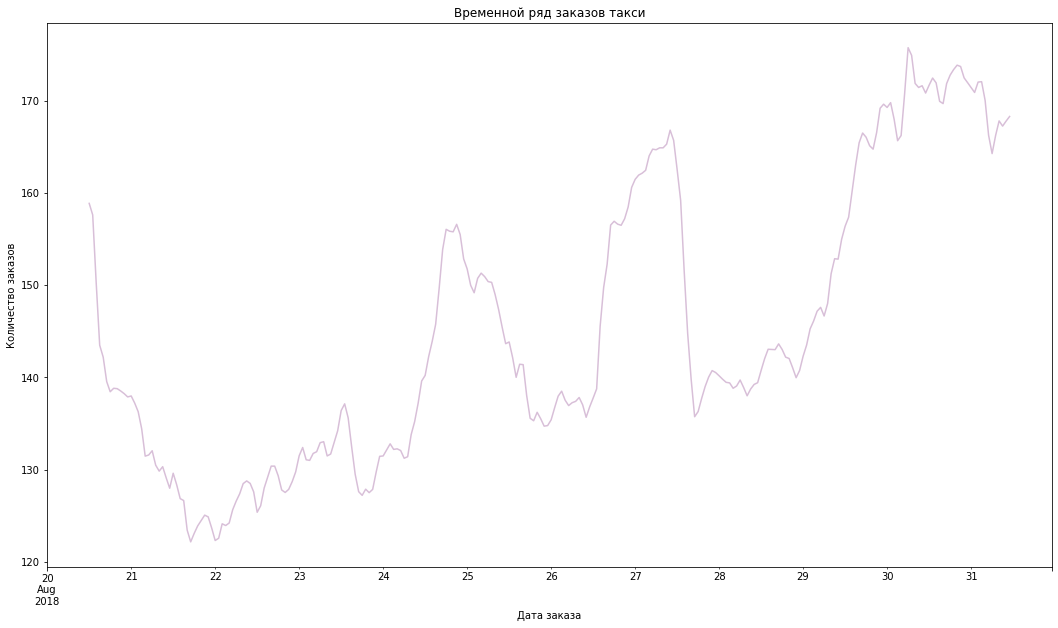

In [13]:
#Посмотрим на тренд заказа такси

decomposed.trend.plot(figsize=(18,10), color = '#D8BFD8')
plt.title('Временной ряд заказов такси')
plt.xlabel('Дата заказа', )
plt.ylabel('Количество заказов');

Можем увидеть тренд на повышение спроса заказа такси.

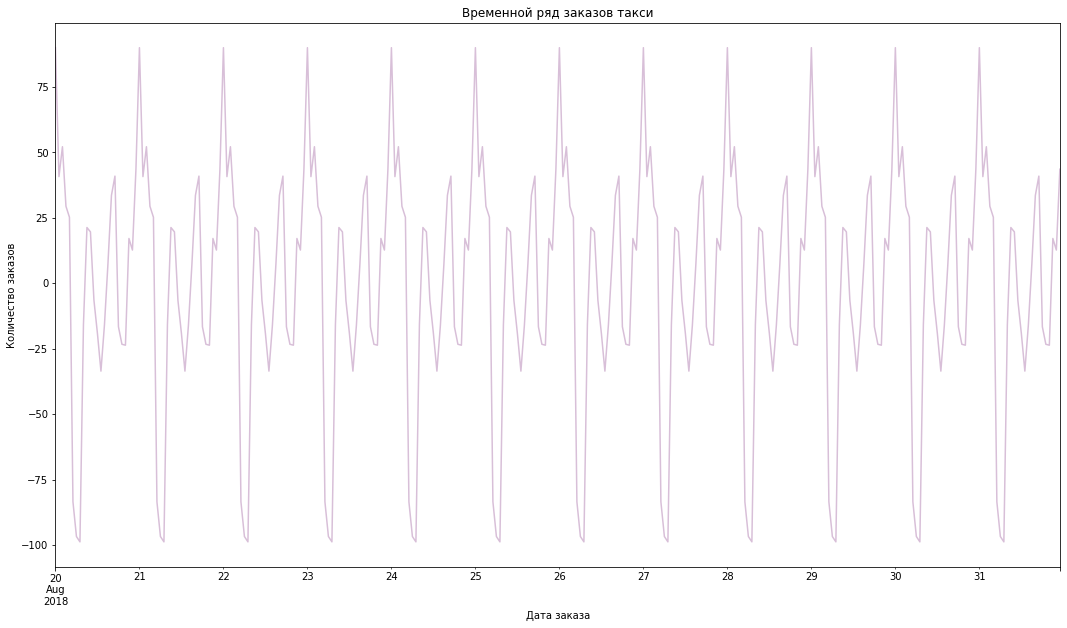

In [14]:
#Посмотрим на сезоннсость заказа такси

decomposed.seasonal.plot(figsize=(18,10), color = '#D8BFD8')
plt.title('Временной ряд заказов такси')
plt.xlabel('Дата заказа', )
plt.ylabel('Количество заказов');

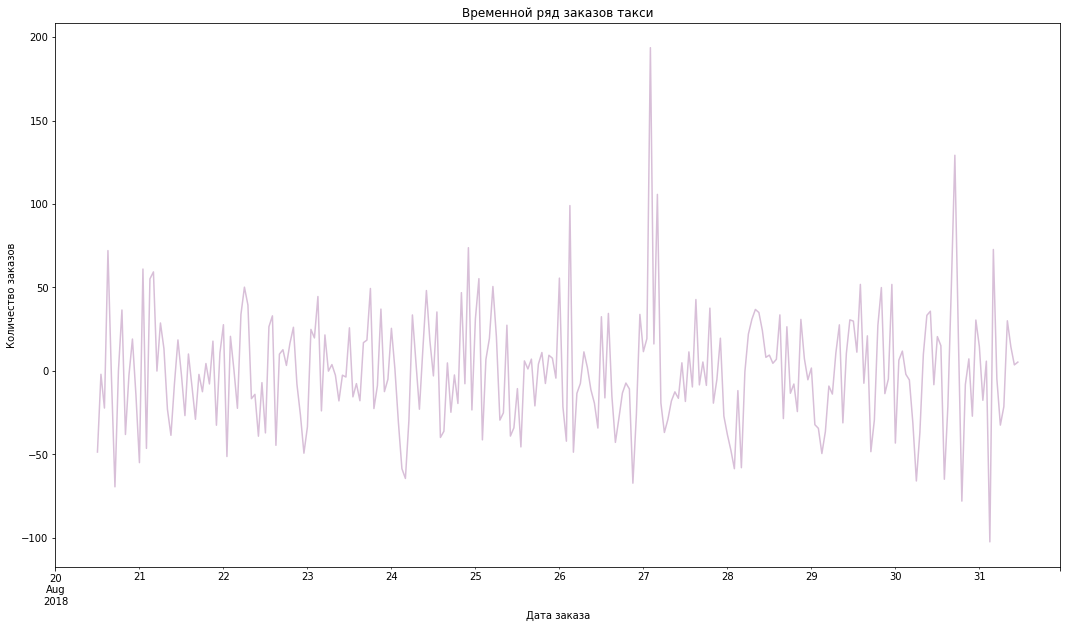

In [15]:
#Посмотрим на остаток декомпозиции заказа такси

decomposed.resid.plot(figsize=(18,10), color = '#D8BFD8')
plt.title('Временной ряд заказов такси')
plt.xlabel('Дата заказа', )
plt.ylabel('Количество заказов');

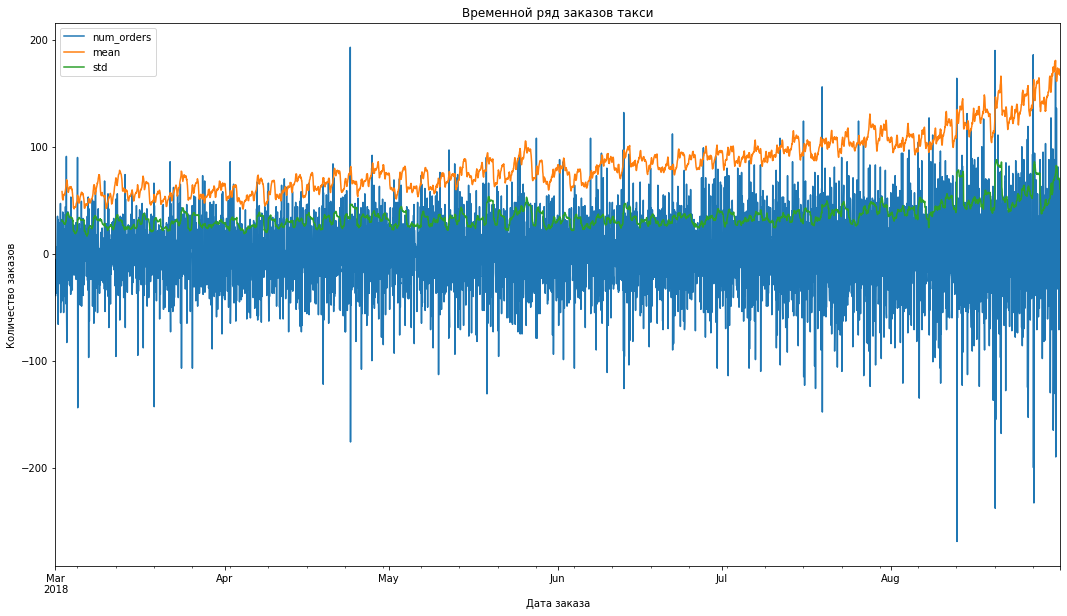

In [16]:
#Посмотрим на среднее и стандартное скользящие

data_shift = data - data.shift()

data_shift['mean'] = data['num_orders'].rolling(30).mean()
data_shift['std'] = data['num_orders'].rolling(30).std()

data_shift.plot(figsize=(18,10))
plt.title('Временной ряд заказов такси')
plt.xlabel('Дата заказа', )
plt.ylabel('Количество заказов');

# Вывод

Имеется тренд к увеличению заказов такси, его можно связать с ростом компании. Сезонность присутствует, но только посуточная. Можем наблюдать маленькую активность заказов с утра и ночью, которая сменяется пиковой активностью в вечернее время. Но подобное может быть из-за графиков вылета-прилета аэропорта. 

Создадим признаки для обучения модели. Будем исходить из того, что есть суточная сезонность, то есть max_lag = 24.

In [17]:
#Создадим функцию, блягодаря которой у нас появятся новые признаки

def make_features(data, max_lag, rolling_size):
    data['hour'] = data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_size).mean()

In [18]:
#Создадим новые признаки

data_features = data.copy(deep=True)

make_features(data_features, 24, 30)

data_features.head(10)

,num_orders,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,5,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,6,6.0,43.0,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,7,12.0,6.0,43.0,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,8,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
#Удалим строки с пропусками

data_features = data_features.dropna()

data_features.head(10)

,num_orders,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 06:00:00,11,6,11.0,20.0,64.0,75.0,120.0,90.0,58.0,113.0,...,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,58.133333
2018-03-02 07:00:00,7,7,11.0,11.0,20.0,64.0,75.0,120.0,90.0,58.0,...,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,54.366667
2018-03-02 08:00:00,46,8,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0,...,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,51.766667
2018-03-02 09:00:00,45,9,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,...,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,50.933333
2018-03-02 10:00:00,54,10,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,...,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,50.233333
2018-03-02 11:00:00,91,11,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,...,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,50.600000
2018-03-02 12:00:00,36,12,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,...,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0,53.433333
2018-03-02 13:00:00,45,13,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0,...,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,54.233333
2018-03-02 14:00:00,44,14,45.0,36.0,91.0,54.0,45.0,46.0,7.0,11.0,...,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,55.233333


Разделим выборки на обучающую, валидационную и тестовую.

In [20]:
# выделяем тестовую выборку в размере 10% от исходного датасет:

train, test = train_test_split(data_features, shuffle=False, test_size=0.1)

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [21]:
#Посмотрим на размеры выборок

features_train.shape, features_test.shape

((3947, 26), (439, 26))

In [22]:
#Создадим функцию для вычисления RSME

def RMSE(target, predicted):
    return (mean_squared_error(target, predicted))**0.5
rmse_score = make_scorer(RMSE, greater_is_better=False)

## Обучение

# LinearRegression

In [23]:
%%time
model_lr = LinearRegression()

model_lr.fit(features_train, target_train)

model_lr_score = pd.Series(cross_val_score(model_lr,features_train,target_train,scoring=rmse_score)).mean()*(-1)
print('Среднее RMSE:', model_lr_score)

Среднее RMSE: 25.662347952509474
CPU times: user 198 ms, sys: 570 ms, total: 769 ms
Wall time: 735 ms


# RandomForestRegressor

In [33]:
%%time
#Подберем необходимые параметры для модели
cv_m = TimeSeriesSplit(n_splits=3).split(features_train)
parameters = {'n_estimators': range(1,50,5),'max_depth': range(1,15,3)}

model_rf = RandomForestRegressor()

model_rf_grid = GridSearchCV(model_rf, parameters, scoring=rmse_score, cv=cv_m)
model_rf_grid.fit(features_train, target_train)

model_rf_grid.best_params_

#{'max_depth': 10, 'n_estimators': 36}

CPU times: user 46.7 s, sys: 172 ms, total: 46.9 s
Wall time: 46.9 s


{'max_depth': 10, 'n_estimators': 36}

In [25]:
%%time

model_rf_score = model_rf_grid.score(features_train, target_train) * (-1)

print('Среднее RMSE:', model_rf_score)

Среднее RMSE: 10.898548265597777
CPU times: user 35.6 ms, sys: 113 µs, total: 35.8 ms
Wall time: 34.8 ms


# LGBMRegressor

In [36]:
%%time
#Подберем необходимые параметры для модели
cv_m = TimeSeriesSplit(n_splits=3).split(features_train)
parameters = {'num_leaves':[31, 100, 200],'learning_rate':[0.1, 0.3, 0.5],'random_state':[RANDOM_STATE]}

model_lgbm = LGBMRegressor()
lgbm_grid = GridSearchCV(model_lgbm, parameters, cv=cv_m, scoring=rmse_score)
lgbm_grid.fit(features_train, target_train)

lgbm_grid.best_params_

#{'learning_rate': 0.1, 'num_leaves': 200, 'random_state': 12345}

CPU times: user 59.6 s, sys: 208 ms, total: 59.8 s
Wall time: 1min


{'learning_rate': 0.1, 'num_leaves': 200, 'random_state': 12345}

In [37]:
%%time

lgbm_score = lgbm_grid.score(features_train, target_train) * (-1)

print('Среднее RMSE:', lgbm_score)

Среднее RMSE: 4.4812415021547105
CPU times: user 111 ms, sys: 0 ns, total: 111 ms
Wall time: 48.6 ms


# CatBoostRegressor

In [38]:
%%time
#Подберем необходимые параметры для модели

cv_m = TimeSeriesSplit(n_splits=3).split(features_train)

model_cat = CatBoostRegressor(loss_function='RMSE',silent=True, random_seed=RANDOM_STATE)
parameters = {'iterations': range(20, 80, 20),'depth': range(5,15,3), 'learning_rate':[0.1, 0.3, 0.5]}

cat_grid = GridSearchCV(model_cat, parameters, cv=cv_m, scoring=rmse_score)
cat_grid.fit(features_train, target_train);

cat_grid.best_params_

#{'depth': 5, 'iterations': 60, 'learning_rate': 0.3}

CPU times: user 16min 28s, sys: 36.9 s, total: 17min 5s
Wall time: 18min 30s


{'depth': 5, 'iterations': 60, 'learning_rate': 0.3}

In [29]:
%%time

cat_score = cat_grid.score(features_train, target_train) * (-1)

print('Среднее RMSE:', cat_score)

Среднее RMSE: 18.770669772775104
CPU times: user 5.61 ms, sys: 62 µs, total: 5.67 ms
Wall time: 4.28 ms


# Вывод

Мы обучили, подобрали гиперпараметры и сделали предсказания на 4-х моделях:

1. LinearRegression;

2. RandomForestRegressor;

3. LGBMRegressor;

4. CatBoostRegressor.

Перейдем к тестированию.

## Тестирование

# LinearRegression;

In [39]:
%%time
#Получим предсказания и вычислим RSME на тестовой выборке

model_lr = LinearRegression()

model_lr.fit(features_train, target_train)

predicted = model_lr.predict(features_test)

print('RMSE:', RMSE(target_test, predicted))

RMSE: 45.40634918040688
CPU times: user 18.2 ms, sys: 94.4 ms, total: 113 ms
Wall time: 90.3 ms


# RandomForestRegressor

In [42]:
%%time
#Получим предсказания и вычислим RSME на тестовой выборке

model_rf = RandomForestRegressor(max_depth=10, n_estimators=36, random_state=RANDOM_STATE)

model_rf.fit(features_train, target_train)

predicted = model_rf.predict(features_test)

print('RMSE:', RMSE(target_test, predicted))

RMSE: 44.40179124189181
CPU times: user 1.22 s, sys: 502 µs, total: 1.22 s
Wall time: 1.22 s


# LGBMRegressor

In [45]:
%%time
#Получим предсказания и вычислим RSME на тестовой выборке

model_lgbr = LGBMRegressor(learning_rate=0.1, num_leaves=200, random_state=RANDOM_STATE)

model_lgbr.fit(features_train, target_train)

predicted = model_lgbr.predict(features_test)

print('RMSE:', RMSE(target_test, predicted))

RMSE: 41.82733904579166
CPU times: user 14.5 s, sys: 8.35 ms, total: 14.5 s
Wall time: 14.7 s


# CatBoostRegressor

In [46]:
%%time
#Получим предсказания и вычислим RSME на тестовой выборке

model_cat = CatBoostRegressor(depth=9, iterations=60, learning_rate=0.3, random_seed=RANDOM_STATE)

model_cat.fit(features_train, target_train)

predicted = model_cat.predict(features_test)

print('RMSE:', RMSE(target_test, predicted))

0:	learn: 33.3707963	total: 57.8ms	remaining: 3.41s
1:	learn: 29.6387824	total: 93.5ms	remaining: 2.71s
2:	learn: 27.0182566	total: 129ms	remaining: 2.45s
3:	learn: 25.2806704	total: 166ms	remaining: 2.33s
4:	learn: 24.1063523	total: 202ms	remaining: 2.22s
5:	learn: 23.2905844	total: 236ms	remaining: 2.12s
6:	learn: 22.3831795	total: 273ms	remaining: 2.06s
7:	learn: 21.8153088	total: 310ms	remaining: 2.02s
8:	learn: 21.3902588	total: 345ms	remaining: 1.96s
9:	learn: 21.3006067	total: 381ms	remaining: 1.91s
10:	learn: 21.0353558	total: 416ms	remaining: 1.85s
11:	learn: 20.6340669	total: 452ms	remaining: 1.81s
12:	learn: 20.4745071	total: 488ms	remaining: 1.76s
13:	learn: 20.3950655	total: 526ms	remaining: 1.73s
14:	learn: 20.0796180	total: 562ms	remaining: 1.69s
15:	learn: 19.7837604	total: 600ms	remaining: 1.65s
16:	learn: 19.7181093	total: 637ms	remaining: 1.61s
17:	learn: 19.5705650	total: 676ms	remaining: 1.58s
18:	learn: 19.4180996	total: 715ms	remaining: 1.54s
19:	learn: 19.309203

In [47]:
%%time
#Вычислим RSME констатной модели

model_const = DummyRegressor(strategy="mean")

model_const.fit(features_train, target_train)

predicted = model_const.predict(features_test)
print(print('RMSE:', RMSE(target_test,predicted)))

RMSE: 84.69779992674266
None
CPU times: user 0 ns, sys: 3.14 ms, total: 3.14 ms
Wall time: 2.31 ms


In [48]:
#Составим таблицу для анализа моделей

data_tabl=[45.40, 44.40, 41.82, 48.90, 84.69]
model_tabl=['LinearRegression', 'RandomForestRegressor', 'LGBMRegressor', 'CatBoostRegressor', 'Const_model']

pd.DataFrame(data=data_tabl, index=model_tabl, columns=['RMSE'])

,RMSE
LinearRegression,45.40
RandomForestRegressor,44.40
LGBMRegressor,41.82
CatBoostRegressor,48.90
Const_model,84.69


По условию задания нужно достигнуть значение метрики RMSE на тестовой не больше 48. RSME нашей лучшей модели(LGBMRegressor) оказалось 41.82, что удовлетворяет условию задачи. С помощью константной модели проверили модель на адекватность. Модель адекватна.

# Вывод

Данные были загружены и проанализированы. Определили, что предоставленные нам данные были собраны за полгода. Минимальное количество заказов за час было 0, максимальное 462. Среднее же количество за час 84. Имеется тренд к увеличению заказов такси, его можно связать с ростом компании. Сезонность присутствует, но только посуточная. Можем наблюдать маленькую активность заказов с утра и ночью, которая сменяется пиковой активностью в вечернее время. Но подобное может быть из-за графиков вылета-прилета аэропорта. Создали дополнительные признаки для обучения модели. Подобрали гиперпараметры для моделей RandomForestRegressor, LGBMRegressor, CatBoostRegressor. Обучили модели, получили предсказания и вычислили RSME для каждой модели. Лучшее значение метрики RSME оказалось у модели LGBMRegressor. Проверили ее на тестовой выборке и получили RSME=41.82.